<a href="https://colab.research.google.com/github/phyron92/A3581/blob/main/bcgtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks') 

Mounted at /content/drive


In [2]:
from sii_fit_original import SII
from fit_routine_original import WLAX, Lines, lines, sii_doublet, c, z
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
hdul1 = fits.open("/content/drive/My Drive/Colab Notebooks/ADP.2016-06-03T11_20_45.461.fits")
head = hdul1[1].header
cubehdu = hdul1[1]
cubehead = cubehdu.header
cube = cubehdu.data

varc = hdul1[2].data

hdul2 = fits.open("/content/drive/My Drive/Colab Notebooks/continuum spectrum.fits")
basespec = hdul2[0].data

sii = SII('SII', lines['SII'][0], lines['SII'][1], lines['SII'][2], cube, varc, basespec)

In [5]:
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = sii.obs[0]
mask = (sii.lranges[0] < sii.wlax) & (sii.wlax < sii.lranges[1])
l_wlax = sii.wlax[mask]
l_lranges = sii.lranges

stime = time.time()
for i in tqdm(range(179,190), smoothing=1):
    for j in range(179,190):

        fit_spec, err_spec = sii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej +=1
            sii.rejcube[0,i,j] = 1
            continue

        try:

            popt, pcov = curve_fit(sii_doublet, l_wlax, fit_spec[mask], p0=[1760, 1500, obs_0, 2.3, 0], 
                                    bounds=([0,0,l_lranges[0],0, -50], [3e4, 3e4, l_lranges[1], 50, 50]), 
                                    absolute_sigma=True, sigma=err_spec[mask])

            uncertainty = np.sqrt(np.diagonal(np.abs(pcov))[0:6])
            snr1 = popt[0] / uncertainty[0]
            snr2 = popt[1] / uncertainty[1]

            if  snr1 > 3. and snr2 > 3.:
                sii.fitcube[:5,i,j] = popt[:]
                sii.fitcube[5,i,j] = snr1
                sii.fitcube[6,i,j] = snr2
                sii.fiterrcube[:,i,j] = uncertainty
            else:
                sii.fitcube[:5,i,j] = np.nan
                sii.fitcube[5,i,j] = snr1
                sii.fitcube[6,i,j] = snr2

                sii.rejcube[1,i,j] = 1
                snrrej += 1

        except (RuntimeError, ValueError):
            sii.set_to_nan(i, j)
            sii.rejcube[2,i,j] = 1
            runerr +=1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)

newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(sii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(sii.fitcube[i]) for i in range(1,sii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(sii.fiterrcube[i]) for i in range(sii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto("/content/drive/My Drive/Colab Notebooks/trial_sii_fit_cont.fits", overwrite = True)

rejhdus = fits.PrimaryHDU(sii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(sii.rejcube[i]) for i in range(1,sii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto("/content/drive/My Drive/Colab Notebooks/trial_sii_rej_cont.fits", overwrite = True)

detectedimg = np.nan_to_num(sii.fitcube[0])
snrrejimg = np.nan_to_num(sii.rejcube[1])
evalimg = detectedimg + snrrejimg

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto("/content/drive/My Drive/Colab Notebooks/trial_sii_eval_cont.fits", overwrite = True)

flux0hdus = [prihdu]
flux1hdus = [fits.ImageHDU(sii.fitcube[1])]
velhdus = [fits.ImageHDU(c*(sii.fitcube[2]/sii.rest[0]-1-z))]
vdisphdus = [fits.ImageHDU(c*(sii.fitcube[3]/sii.rest[0]))]
resulthdus =  fits.HDUList(flux0hdus+flux1hdus+velhdus+vdisphdus)
resulthdus.writeto("/content/drive/My Drive/Colab Notebooks/trial_sii_result_cont.fits", overwrite=True)

100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


0
0
0
7.55192756652832


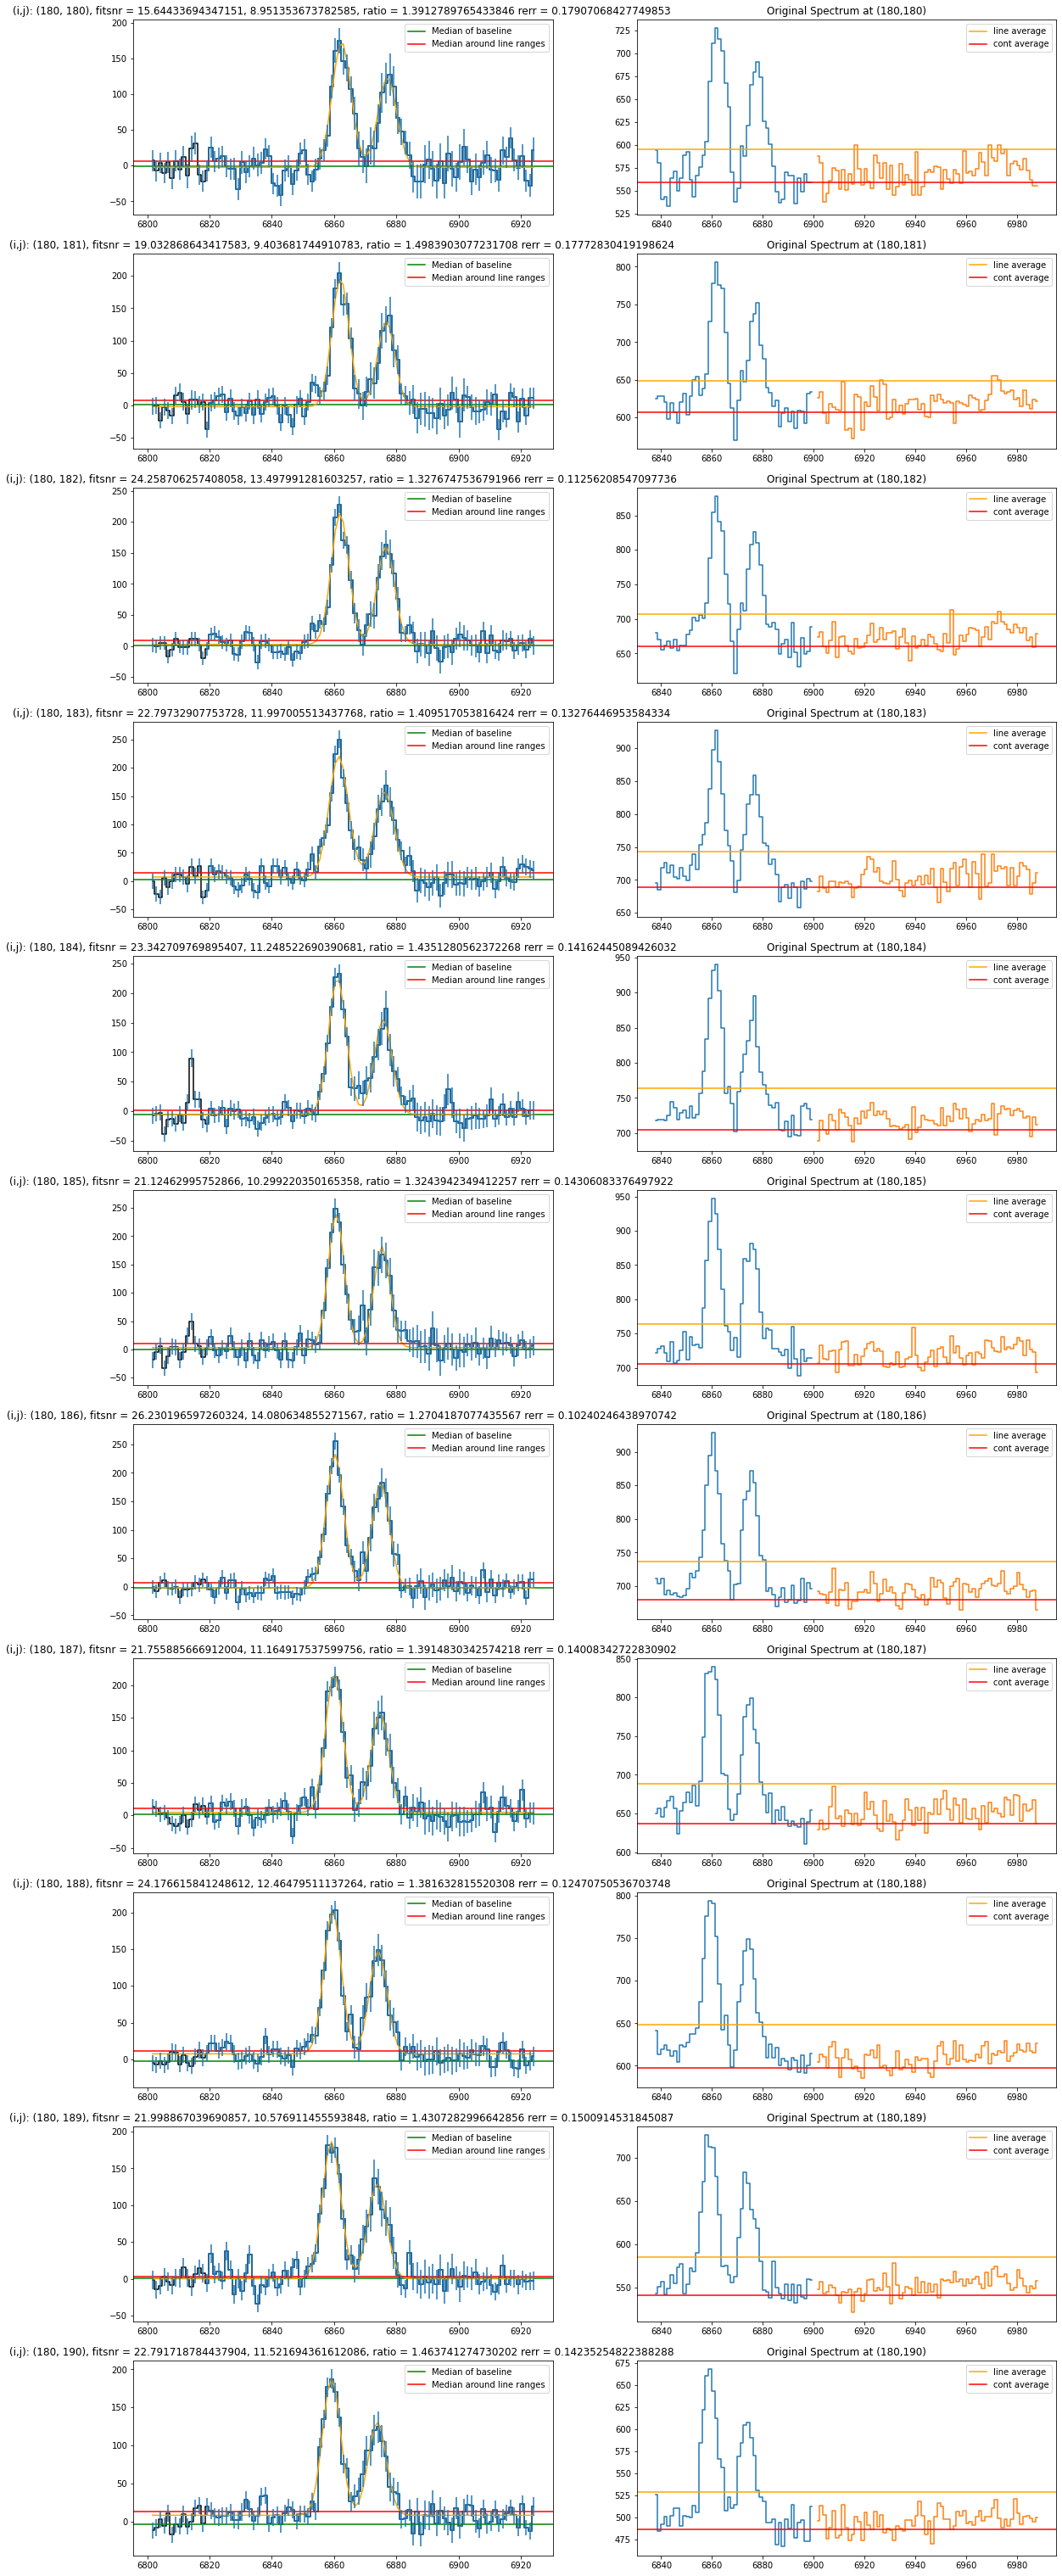

In [6]:
HIGH_CONT = [(180,180), (180,181) ,(180, 182), (180,183), (180,184),(180,185),(180,186),(180,187),(180,188),(180,189),(180,190)]
sii.plot_eval(HIGH_CONT)